In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re
import os
import matplotlib.ticker as ticker
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix, classification_report

# 设置可视化样式和颜色主题
plt.style.use('ggplot')
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (12, 8)
colors = {
    "positive": "#2ecc71",  # 绿色
    "negative": "#e74c3c",  # 红色
    "neutral": "#3498db"    # 蓝色
}

# 确保输出目录存在
output_dir = "sst2_eda_results"
os.makedirs(output_dir, exist_ok=True)

In [2]:
# 加载数据
def load_sst2_data():
    print("Loading SST-2 dataset...")
    datasets = load_dataset("glue", "sst2")
    train_data = datasets["train"]
    valid_data = datasets["validation"]
    return datasets, train_data, valid_data

In [3]:
# 1. 数据集基本信息分析
def dataset_info(dataset, name):
    print(f"\n===== {name} Dataset Information =====")
    print(f"Number of samples: {len(dataset)}")
    
    # 转换为DataFrame方便操作
    df = pd.DataFrame(dataset)
    
    # 类别分布
    print("\nClass distribution:")
    class_counts = df['label'].value_counts().sort_index()
    print(class_counts)
    print(f"Class distribution ratio: {class_counts / len(df)}")
    
    # 可视化类别分布
    plt.figure(figsize=(10, 7))
    ax = sns.countplot(x='label', data=df, palette=[colors["negative"], colors["positive"]], hue='label', legend=False)
    plt.title(f"{name} Dataset Class Distribution", fontsize=15, pad=20)
    plt.xlabel("Label (0=Negative, 1=Positive)", fontsize=13)
    plt.ylabel("Sample Count", fontsize=13)
    plt.grid(axis='y', alpha=0.3)
    
    # 在柱状图上显示数值
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                   (p.get_x() + p.get_width() / 2., p.get_height() + 0.1), 
                   ha = 'center', va = 'bottom', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{name}_class_distribution.png", dpi=300)
    plt.show()
    
    return df

In [4]:
# 2. 文本长度分析
def text_length_analysis(dataset, name):
    print(f"\n===== {name} Dataset Text Length Analysis =====")
    
    df = pd.DataFrame(dataset)
    # 计算各种长度指标
    df['text_length'] = df['sentence'].apply(len)
    df['word_count'] = df['sentence'].apply(lambda x: len(x.split()))
    df['avg_word_length'] = df['sentence'].apply(lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0)
    
    # 基本统计
    print("\nText character length statistics:")
    print(df['text_length'].describe())
    print("\nWord count statistics:")
    print(df['word_count'].describe())
    print("\nAverage word length statistics:")
    print(df['avg_word_length'].describe())
    
    # 绘制长度分布直方图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # 字符长度分布
    sns.histplot(df['text_length'], ax=ax1, kde=True, bins=30, color=colors["neutral"])
    ax1.set_title(f"{name} Dataset Text Character Length Distribution", fontsize=14)
    ax1.set_xlabel("Character Count", fontsize=12)
    ax1.set_ylabel("Frequency", fontsize=12)
    ax1.grid(alpha=0.3)
    
    # 词数分布
    sns.histplot(df['word_count'], ax=ax2, kde=True, bins=30, color=colors["neutral"])
    ax2.set_title(f"{name} Dataset Word Count Distribution", fontsize=14)
    ax2.set_xlabel("Word Count", fontsize=12)
    ax2.set_ylabel("Frequency", fontsize=12)
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{name}_length_distributions.png", dpi=300)
    plt.show()
    
    # 按情感标签比较长度的箱形图
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 7))
    
    sns.boxplot(x='label', y='text_length', data=df, ax=ax1, palette=[colors["negative"], colors["positive"]], hue='label', legend=False)
    ax1.set_title("Text Length by Sentiment", fontsize=14)
    ax1.set_xlabel("Sentiment Label (0=Negative, 1=Positive)", fontsize=12)
    ax1.set_ylabel("Character Count", fontsize=12)
    ax1.grid(axis='y', alpha=0.3)
    
    sns.boxplot(x='label', y='word_count', data=df, ax=ax2, palette=[colors["negative"], colors["positive"]], hue='label', legend=False)
    ax2.set_title("Word Count by Sentiment", fontsize=14)
    ax2.set_xlabel("Sentiment Label (0=Negative, 1=Positive)", fontsize=12)
    ax2.set_ylabel("Word Count", fontsize=12)
    ax2.grid(axis='y', alpha=0.3)
    
    sns.boxplot(x='label', y='avg_word_length', data=df, ax=ax3, palette=[colors["negative"], colors["positive"]], hue='label', legend=False)
    ax3.set_title("Avg Word Length by Sentiment", fontsize=14)
    ax3.set_xlabel("Sentiment Label (0=Negative, 1=Positive)", fontsize=12)
    ax3.set_ylabel("Average Word Length", fontsize=12)
    ax3.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{name}_length_by_sentiment.png", dpi=300)
    plt.show()
    
    return df

In [5]:
# 3. 文本复杂度分析
def text_complexity_analysis(dataset, name):
    print(f"\n===== {name} Dataset Text Complexity Analysis =====")
    
    df = pd.DataFrame(dataset)
    # 计算平均词长
    df['avg_word_length'] = df['sentence'].apply(lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0)
    # 计算标点符号频率
    df['punctuation_rate'] = df['sentence'].apply(lambda x: len(re.findall(r'[^\w\s]', x)) / len(x) if len(x) > 0 else 0)
    # 计算大写字母比例
    df['capital_rate'] = df['sentence'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
    
    # 输出基本统计
    print("\nText complexity statistics:")
    print("Average word length statistics:")
    print(df['avg_word_length'].describe())
    print("\nPunctuation rate statistics:")
    print(df['punctuation_rate'].describe())
    print("\nCapital letter rate statistics:")
    print(df['capital_rate'].describe())
    
    # 可视化这些复杂度指标
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    # 平均词长分布
    sns.histplot(df['avg_word_length'], ax=ax1, kde=True, color=colors["neutral"])
    ax1.set_title("Average Word Length Distribution", fontsize=14)
    ax1.set_xlabel("Average Word Length", fontsize=12)
    ax1.set_ylabel("Frequency", fontsize=12)
    ax1.grid(alpha=0.3)
    
    # 标点符号率分布
    sns.histplot(df['punctuation_rate'], ax=ax2, kde=True, color=colors["neutral"])
    ax2.set_title("Punctuation Rate Distribution", fontsize=14)
    ax2.set_xlabel("Punctuation Rate", fontsize=12)
    ax2.set_ylabel("Frequency", fontsize=12)
    ax2.grid(alpha=0.3)
    
    # 大写字母率分布
    sns.histplot(df['capital_rate'], ax=ax3, kde=True, color=colors["neutral"])
    ax3.set_title("Capital Letter Rate Distribution", fontsize=14)
    ax3.set_xlabel("Capital Letter Rate", fontsize=12)
    ax3.set_ylabel("Frequency", fontsize=12)
    ax3.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{name}_complexity_distributions.png", dpi=300)
    plt.show()
    
    # 比较不同情感标签的复杂度指标
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    sns.boxplot(x='label', y='avg_word_length', data=df, ax=ax1, palette=[colors["negative"], colors["positive"]], hue='label', legend=False)
    ax1.set_title("Average Word Length by Sentiment", fontsize=14)
    ax1.set_xlabel("Sentiment Label (0=Negative, 1=Positive)", fontsize=12)
    ax1.set_ylabel("Average Word Length", fontsize=12)
    ax1.grid(axis='y', alpha=0.3)
    
    sns.boxplot(x='label', y='punctuation_rate', data=df, ax=ax2, palette=[colors["negative"], colors["positive"]], hue='label', legend=False)
    ax2.set_title("Punctuation Rate by Sentiment", fontsize=14)
    ax2.set_xlabel("Sentiment Label (0=Negative, 1=Positive)", fontsize=12)
    ax2.set_ylabel("Punctuation Rate", fontsize=12)
    ax2.grid(axis='y', alpha=0.3)
    
    sns.boxplot(x='label', y='capital_rate', data=df, ax=ax3, palette=[colors["negative"], colors["positive"]], hue='label', legend=False)
    ax3.set_title("Capital Letter Rate by Sentiment", fontsize=14)
    ax3.set_xlabel("Sentiment Label (0=Negative, 1=Positive)", fontsize=12)
    ax3.set_ylabel("Capital Letter Rate", fontsize=12)
    ax3.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{name}_complexity_by_sentiment.png", dpi=300)
    plt.show()
    
    return df

In [6]:
# 4. 数据质量分析
def data_quality_analysis(dataset, name):
    print(f"\n===== {name} Dataset Quality Analysis =====")
    
    df = pd.DataFrame(dataset)
    # 添加词数统计
    df['word_count'] = df['sentence'].apply(lambda x: len(x.split()))
    
    # 检查重复项
    duplicates = df.duplicated(subset=['sentence']).sum()
    print(f"Number of duplicate sentences: {duplicates} ({duplicates/len(df)*100:.2f}%)")
    
    # 检查极端情况
    extremely_short = (df['word_count'] <= 3).sum()
    print(f"Extremely short sentences (<=3 words): {extremely_short} ({extremely_short/len(df)*100:.2f}%)")
    
    extremely_long = (df['word_count'] >= 30).sum()
    print(f"Extremely long sentences (>=30 words): {extremely_long} ({extremely_long/len(df)*100:.2f}%)")
    
    # 空白和特殊字符检查
    has_leading_spaces = df['sentence'].apply(lambda x: x.startswith(' ')).sum()
    print(f"Sentences with leading spaces: {has_leading_spaces} ({has_leading_spaces/len(df)*100:.2f}%)")
    
    has_trailing_spaces = df['sentence'].apply(lambda x: x.endswith(' ')).sum()
    print(f"Sentences with trailing spaces: {has_trailing_spaces} ({has_trailing_spaces/len(df)*100:.2f}%)")
    
    has_special_chars = df['sentence'].apply(lambda x: bool(re.search(r'[^\w\s,.!?;:\'\"-]', x))).sum()
    print(f"Sentences with special characters: {has_special_chars} ({has_special_chars/len(df)*100:.2f}%)")
    
    # 情感标签分布再次检查
    sentiment_balance = df['label'].value_counts(normalize=True)
    print("\nSentiment label distribution:")
    print(sentiment_balance)
    
    # 如果有重复项，展示一些例子
    if duplicates > 0:
        print("\nSample duplicate sentences:")
        duplicate_mask = df.duplicated(subset=['sentence'], keep=False)
        for sentence, count in Counter(df[duplicate_mask]['sentence']).most_common(5):
            print(f"'{sentence}' appears {count} times")
    
    # 可视化一些质量指标
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # 极端短句和长句比例
    labels = ['Short (<=3)', 'Normal', 'Long (>=30)']
    sizes = [extremely_short, len(df) - extremely_short - extremely_long, extremely_long]
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, 
            colors=[colors["negative"], colors["neutral"], colors["positive"]])
    ax1.set_title('Sentence Length Distribution', fontsize=14)
    
    # 特殊字符比例
    labels = ['With Special Chars', 'Without Special Chars']
    sizes = [has_special_chars, len(df) - has_special_chars]
    ax2.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90,
            colors=[colors["negative"], colors["positive"]])
    ax2.set_title('Special Character Distribution', fontsize=14)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{name}_data_quality.png", dpi=300)
    plt.show()
    
    return df

In [7]:
# 5. 词频分析
def word_frequency_analysis(dataset, name):
    print(f"\n===== {name} Dataset Word Frequency Analysis =====")
    
    # 确保nltk停用词已下载
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')
    
    stop_words = set(stopwords.words('english'))
    df = pd.DataFrame(dataset)
    
    # 通用处理文本函数
    def process_text(texts):
        processed_words = []
        for text in texts:
            # 转小写，去标点，分词
            words = re.sub(r'[^\w\s]', '', text.lower()).split()
            # 去停用词
            words = [word for word in words if word not in stop_words]
            processed_words.extend(words)
        return processed_words
    
    # 处理所有文本
    all_words = process_text(df['sentence'])
    
    # 计算词频
    word_counts = Counter(all_words)
    most_common = word_counts.most_common(25)  # 增加到25个词
    
    # 转为DataFrame便于绘图
    word_df = pd.DataFrame(most_common, columns=['word', 'count'])
    
    # 绘制词频条形图
    plt.figure(figsize=(14, 10))
    ax = sns.barplot(x='count', y='word', data=word_df, palette="viridis", hue='word', legend=False)
    plt.title(f"{name} Dataset Top 25 Most Common Words", fontsize=16)
    plt.xlabel("Frequency", fontsize=14)
    plt.ylabel("Word", fontsize=14)
    plt.grid(axis='x', alpha=0.3)
    
    # 在条形上显示数值
    for i, v in enumerate(word_df['count']):
        ax.text(v + 0.5, i, str(v), va='center')
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{name}_top_words.png", dpi=300)
    plt.show()
    
    # 词云可视化
    plt.figure(figsize=(14, 10))
    wordcloud = WordCloud(width=1000, height=600, 
                          background_color='white',
                          max_words=200,
                          contour_width=3,
                          contour_color='steelblue',
                          colormap='viridis',
                          random_state=42)
    
    # 生成词云
    wordcloud.generate_from_frequencies(word_counts)
    
    # 显示词云
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{name} Dataset Word Cloud", fontsize=20)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{name}_wordcloud.png", dpi=300)
    plt.show()
    
    # 按情感标签分析词频
    positive_texts = df[df['label'] == 1]['sentence'].tolist()
    negative_texts = df[df['label'] == 0]['sentence'].tolist()
    
    # 处理正面和负面评论
    pos_words = process_text(positive_texts)
    neg_words = process_text(negative_texts)
    
    pos_word_counts = Counter(pos_words)
    neg_word_counts = Counter(neg_words)
    
    # 转为DataFrame
    pos_df = pd.DataFrame(pos_word_counts.most_common(15), columns=['word', 'count'])
    neg_df = pd.DataFrame(neg_word_counts.most_common(15), columns=['word', 'count'])
    
    # 比较正负面评论的词频
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
    
    sns.barplot(x='count', y='word', data=pos_df, ax=ax1, palette=f'dark:{colors["positive"]}', hue='word', legend=False)
    ax1.set_title("Top 15 Words in Positive Reviews", fontsize=16)
    ax1.set_xlabel("Frequency", fontsize=14)
    ax1.set_ylabel("Word", fontsize=14)
    ax1.grid(axis='x', alpha=0.3)
    for i, v in enumerate(pos_df['count']):
        ax1.text(v + 0.5, i, str(v), va='center')
    
    sns.barplot(x='count', y='word', data=neg_df, ax=ax2, palette=f'dark:{colors["negative"]}', hue='word', legend=False)
    ax2.set_title("Top 15 Words in Negative Reviews", fontsize=16)
    ax2.set_xlabel("Frequency", fontsize=14)
    ax2.set_ylabel("Word", fontsize=14)
    ax2.grid(axis='x', alpha=0.3)
    for i, v in enumerate(neg_df['count']):
        ax2.text(v + 0.5, i, str(v), va='center')
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{name}_sentiment_words.png", dpi=300)
    plt.show()
    
    # 正负面评论词云
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
    
    # 正面评论词云
    pos_wordcloud = WordCloud(width=800, height=400, 
                          background_color='white',
                          max_words=100,
                          contour_width=3,
                          contour_color='steelblue',
                          colormap='Greens',
                          random_state=42)
    pos_wordcloud.generate_from_frequencies(pos_word_counts)
    ax1.imshow(pos_wordcloud, interpolation='bilinear')
    ax1.axis('off')
    ax1.set_title("Positive Reviews Word Cloud", fontsize=20)
    
    # 负面评论词云
    neg_wordcloud = WordCloud(width=800, height=400, 
                          background_color='white',
                          max_words=100,
                          contour_width=3,
                          contour_color='steelblue',
                          colormap='Reds',
                          random_state=42)
    neg_wordcloud.generate_from_frequencies(neg_word_counts)
    ax2.imshow(neg_wordcloud, interpolation='bilinear')
    ax2.axis('off')
    ax2.set_title("Negative Reviews Word Cloud", fontsize=20)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{name}_sentiment_wordclouds.png", dpi=300)
    plt.show()

In [8]:
# 6. N-gram分析
def ngram_analysis(dataset, name, n=2):
    print(f"\n===== {name} Dataset {n}-gram Analysis =====")
    
    df = pd.DataFrame(dataset)
    stop_words = set(stopwords.words('english'))
    
    # 处理所有文本并提取n-grams
    all_texts = []
    for text in df['sentence']:
        # 清理文本（保留空格用于ngram分析）
        cleaned_text = re.sub(r'[^\w\s]', '', text.lower())
        all_texts.append(cleaned_text)
    
    # 使用CountVectorizer来提取n-grams
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    X = vectorizer.fit_transform(all_texts)
    
    # 获取n-gram列表及其计数
    ngram_counts = np.sum(X, axis=0).tolist()[0]
    ngrams = vectorizer.get_feature_names_out()
    
    # 创建n-gram和计数的列表
    ngram_count_pairs = list(zip(ngrams, ngram_counts))
    
    # 按计数排序
    most_common = sorted(ngram_count_pairs, key=lambda x: x[1], reverse=True)[:20]
    
    # 可视化
    ngram_df = pd.DataFrame(most_common, columns=['ngram', 'count'])
    
    plt.figure(figsize=(14, 10))
    ax = sns.barplot(x='count', y='ngram', data=ngram_df, palette="viridis", hue='ngram', legend=False)
    plt.title(f"Top 20 Most Common {n}-grams", fontsize=16)
    plt.xlabel("Frequency", fontsize=14)
    plt.ylabel(f"{n}-gram", fontsize=14)
    plt.grid(axis='x', alpha=0.3)
    
    # 在条形上显示数值
    for i, v in enumerate(ngram_df['count']):
        ax.text(v + 0.5, i, str(v), va='center')
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{name}_{n}gram_analysis.png", dpi=300)
    plt.show()
    
    # 按情感标签分析n-grams
    positive_texts = [re.sub(r'[^\w\s]', '', text.lower()) for text in df[df['label'] == 1]['sentence']]
    negative_texts = [re.sub(r'[^\w\s]', '', text.lower()) for text in df[df['label'] == 0]['sentence']]
    
    # 处理正面评论
    pos_vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    pos_X = pos_vectorizer.fit_transform(positive_texts)
    pos_counts = np.sum(pos_X, axis=0).tolist()[0]
    pos_ngrams = pos_vectorizer.get_feature_names_out()
    pos_ngram_counts = sorted(list(zip(pos_ngrams, pos_counts)), key=lambda x: x[1], reverse=True)[:15]
    pos_ngram_df = pd.DataFrame(pos_ngram_counts, columns=['ngram', 'count'])
    
    # 处理负面评论
    neg_vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    neg_X = neg_vectorizer.fit_transform(negative_texts)
    neg_counts = np.sum(neg_X, axis=0).tolist()[0]
    neg_ngrams = neg_vectorizer.get_feature_names_out()
    neg_ngram_counts = sorted(list(zip(neg_ngrams, neg_counts)), key=lambda x: x[1], reverse=True)[:15]
    neg_ngram_df = pd.DataFrame(neg_ngram_counts, columns=['ngram', 'count'])
    
    # 可视化正负评论的n-gram对比
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
    
    sns.barplot(x='count', y='ngram', data=pos_ngram_df, ax=ax1, palette=f'dark:{colors["positive"]}', hue='ngram', legend=False)
    ax1.set_title(f"Top 15 {n}-grams in Positive Reviews", fontsize=16)
    ax1.set_xlabel("Frequency", fontsize=14)
    ax1.set_ylabel(f"{n}-gram", fontsize=14)
    ax1.grid(axis='x', alpha=0.3)
    for i, v in enumerate(pos_ngram_df['count']):
        ax1.text(v + 0.5, i, str(v), va='center')
    
    sns.barplot(x='count', y='ngram', data=neg_ngram_df, ax=ax2, palette=f'dark:{colors["negative"]}', hue='ngram', legend=False)
    ax2.set_title(f"Top 15 {n}-grams in Negative Reviews", fontsize=16)
    ax2.set_xlabel("Frequency", fontsize=14)
    ax2.set_ylabel(f"{n}-gram", fontsize=14)
    ax2.grid(axis='x', alpha=0.3)
    for i, v in enumerate(neg_ngram_df['count']):
        ax2.text(v + 0.5, i, str(v), va='center')
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{name}_{n}gram_sentiment_analysis.png", dpi=300)
    plt.show()

In [9]:
# 7. 情感强度分析
def sentiment_intensity_analysis(dataset, name):
    print(f"\n===== {name} Dataset Sentiment Intensity Analysis =====")
    
    # 确保nltk vader情感分析器已下载
    try:
        nltk.data.find('sentiment/vader_lexicon.zip')
    except LookupError:
        nltk.download('vader_lexicon')
    
    df = pd.DataFrame(dataset)
    sid = SentimentIntensityAnalyzer()
    
    # 计算每句话的情感分数
    df['sentiment_scores'] = df['sentence'].apply(lambda x: sid.polarity_scores(x))
    df['compound_score'] = df['sentiment_scores'].apply(lambda x: x['compound'])
    df['positive_score'] = df['sentiment_scores'].apply(lambda x: x['pos'])
    df['negative_score'] = df['sentiment_scores'].apply(lambda x: x['neg'])
    df['neutral_score'] = df['sentiment_scores'].apply(lambda x: x['neu'])
    
    # 输出情感分数统计
    print("\nCompound sentiment score statistics:")
    print(df['compound_score'].describe())
    
    # 可视化情感复合得分分布
    plt.figure(figsize=(12, 7))
    sns.histplot(df['compound_score'], kde=True, bins=30, color=colors["neutral"])
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title(f"{name} Dataset Sentiment Compound Score Distribution", fontsize=16)
    plt.xlabel("Compound Score (-1: Extremely Negative, +1: Extremely Positive)", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{name}_sentiment_distribution.png", dpi=300)
    plt.show()
    
    # 比较VADER情感得分与数据集标签的一致性
    # 将复合得分转换为二进制标签（正/负）
    df['vader_prediction'] = df['compound_score'].apply(lambda x: 1 if x >= 0 else 0)
    
    # 计算混淆矩阵
    cm = confusion_matrix(df['label'], df['vader_prediction'])
    
    # 计算分类报告
    print("\nComparison between dataset labels and VADER sentiment predictions:")
    print(classification_report(df['label'], df['vader_prediction']))
    
    # 可视化混淆矩阵
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix: Dataset Labels vs VADER Predictions', fontsize=16)
    plt.ylabel('Dataset Labels', fontsize=14)
    plt.xlabel('VADER Predictions', fontsize=14)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{name}_confusion_matrix.png", dpi=300)
    plt.show()
    
    # 分析情感得分与标签的关系
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='label', y='compound_score', data=df, palette=[colors["negative"], colors["positive"]], hue='label', legend=False)
    plt.title('Sentiment Compound Scores by Dataset Label', fontsize=16)
    plt.xlabel('Dataset Label (0=Negative, 1=Positive)', fontsize=14)
    plt.ylabel('Compound Score', fontsize=14)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{name}_sentiment_by_label.png", dpi=300)
    plt.show()
    
    return df

In [10]:
# 8. 分词数据分析
def analyze_tokenized_data(tokenized_dataset, tokenizer, name):
    print(f"\n===== {name} Tokenized Dataset Analysis =====")
    
    # 确保数据结构正确
    if 'train' not in tokenized_dataset:
        print("Error: Expected 'train' split in tokenized dataset")
        return
    
    # 转换数据为pandas DataFrame - 处理可能的批处理格式
    try:
        # 转换为DataFrame，处理列表和张量格式
        train_data = {
            'input_ids': [ids.tolist() if hasattr(ids, 'tolist') else ids for ids in tokenized_dataset['train']['input_ids']],
            'attention_mask': [mask.tolist() if hasattr(mask, 'tolist') else mask for mask in tokenized_dataset['train']['attention_mask']],
            'labels': [label.item() if hasattr(label, 'item') else label for label in tokenized_dataset['train']['labels']]
        }
        train_df = pd.DataFrame(train_data)
        
        # 计算序列长度（非填充token）
        train_df['seq_length'] = train_df['attention_mask'].apply(sum)
        
        print(f"\nDataset size: {len(train_df)} samples")
        print("\nTokenized sequence length statistics:")
        print(train_df['seq_length'].describe())
        
        # 统计标签分布
        label_counts = train_df['labels'].value_counts()
        print("\nLabel distribution:")
        for label, count in label_counts.items():
            print(f"Label {label}: {count} samples ({count/len(train_df)*100:.2f}%)")
        
        # 绘制序列长度直方图
        plt.figure(figsize=(12, 7))
        sns.histplot(train_df['seq_length'], kde=True, bins=30, color=colors["neutral"])
        plt.title(f"{name} Tokenized Sequence Length Distribution", fontsize=16)
        plt.xlabel("Token Count", fontsize=14)
        plt.ylabel("Frequency", fontsize=14)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(f"{output_dir}/{name}_token_length_distribution.png", dpi=300)
        plt.show()
        
        # 按标签比较序列长度
        plt.figure(figsize=(12, 8))
        sns.boxplot(x='labels', y='seq_length', data=train_df, palette=[colors["negative"], colors["positive"]], hue='labels', legend=False)
        plt.title("Tokenized Sequence Length by Sentiment Category", fontsize=16)
        plt.xlabel("Sentiment Label (0=Negative, 1=Positive)", fontsize=14)
        plt.ylabel("Token Count", fontsize=14)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.savefig(f"{output_dir}/{name}_token_length_by_sentiment.png", dpi=300)
        plt.show()
        
        # 添加子词分析
        print("\nAnalyzing subword tokenization...")
        # 计算平均每个原始单词被分成多少个子词
        sample_size = min(500, len(train_df))  # 取样分析提高效率
        samples = train_df.sample(sample_size)
        
        subword_ratios = []
        for idx, row in samples.iterrows():
            # 重构原始文本（仅用于演示，实际应用可能需要更精确的方法）
            tokens = tokenizer.convert_ids_to_tokens(row['input_ids'])
            # 过滤掉特殊标记如[CLS]、[SEP]和[PAD]
            tokens = [t for t in tokens if not (t.startswith('[') and t.endswith(']'))]
            
            # 计算子词比例 (考虑BERT的##前缀标记子词)
            subwords = sum(1 for t in tokens if t.startswith('##'))
            total_tokens = len(tokens)
            words = total_tokens - subwords
            
            if words > 0:  # 避免除零错误
                ratio = total_tokens / words
                subword_ratios.append(ratio)
        
        print(f"Average subword ratio (tokens per word): {np.mean(subword_ratios):.2f}")
        
        # 可视化子词比例分布
        plt.figure(figsize=(12, 7))
        sns.histplot(subword_ratios, kde=True, bins=20, color=colors["neutral"])
        plt.axvline(x=np.mean(subword_ratios), color='red', linestyle='--', 
                   label=f"Mean: {np.mean(subword_ratios):.2f}")
        plt.title("Subword Tokenization Ratio Distribution", fontsize=16)
        plt.xlabel("Tokens per Word", fontsize=14)
        plt.ylabel("Frequency", fontsize=14)
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(f"{output_dir}/{name}_subword_ratio.png", dpi=300)
        plt.show()
        
        return train_df
        
    except Exception as e:
        print(f"Error analyzing tokenized data: {e}")
        import traceback
        traceback.print_exc()
        return None

In [11]:
# 9. 词-标签相关性分析
def token_label_correlation(tokenized_dataset, tokenizer, name):
    print(f"\n===== {name} Dataset Token-Label Correlation Analysis =====")
    
    try:
        # 获取训练数据
        input_ids = tokenized_dataset['train']['input_ids']
        labels = tokenized_dataset['train']['labels']
        
        # 创建token计数器
        token_pos_counts = {}  # 正面样本中的频率
        token_neg_counts = {}  # 负面样本中的频率
        
        # 按情感类别统计token出现次数
        for i, ids in enumerate(input_ids):
            # 处理张量和列表格式
            ids_list = ids.tolist() if hasattr(ids, 'tolist') else ids
            label = labels[i].item() if hasattr(labels[i], 'item') else labels[i]
            
            for token_id in ids_list:
                token_id = token_id if isinstance(token_id, int) else token_id.item()
                if tokenizer.pad_token_id is not None and token_id == tokenizer.pad_token_id:
                    continue  # 跳过填充token
                    
                if label == 1:  # 正面
                    token_pos_counts[token_id] = token_pos_counts.get(token_id, 0) + 1
                else:  # 负面
                    token_neg_counts[token_id] = token_neg_counts.get(token_id, 0) + 1
        
        # 计算相关性分数 - 简单比率差异
        token_scores = {}
        min_count = 20  # 最小出现阈值，避免稀有token的偏差
        
        total_pos = sum(token_pos_counts.values())
        total_neg = sum(token_neg_counts.values())
        
        print(f"Total positive tokens: {total_pos}, Total negative tokens: {total_neg}")
        
        for token_id in set(token_pos_counts.keys()) | set(token_neg_counts.keys()):
            pos_count = token_pos_counts.get(token_id, 0)
            neg_count = token_neg_counts.get(token_id, 0)
            
            if pos_count + neg_count < min_count:
                continue
                
            # 计算相关性分数（正值=与正面情感相关，负值=与负面情感相关）
            pos_ratio = pos_count / total_pos if total_pos > 0 else 0
            neg_ratio = neg_count / total_neg if total_neg > 0 else 0
            
            # 避免除零
            if max(pos_ratio, neg_ratio) > 0:
                # 修改分数计算以提高可解释性
                score = (pos_ratio - neg_ratio) / (pos_ratio + neg_ratio)
            else:
                score = 0
            
            token_scores[token_id] = score
        
        # 获取相关性最高的tokens
        most_positive = sorted(token_scores.items(), key=lambda x: x[1], reverse=True)[:20]  # 增加到20个
        most_negative = sorted(token_scores.items(), key=lambda x: x[1])[:20]  # 增加到20个
        
        print(f"Found {len(token_scores)} tokens with sufficient frequency")
        print(f"Top positive correlation score: {most_positive[0][1] if most_positive else 'N/A'}")
        print(f"Top negative correlation score: {most_negative[0][1] if most_negative else 'N/A'}")
        
        # 尝试将token_ids转换为实际词汇
        try:
            # 检查是否可以转换tokens
            if hasattr(tokenizer, 'convert_ids_to_tokens'):
                pos_tokens = [(tokenizer.convert_ids_to_tokens(token_id), score) 
                             for token_id, score in most_positive]
                neg_tokens = [(tokenizer.convert_ids_to_tokens(token_id), score) 
                             for token_id, score in most_negative]
                
                # 创建DataFrames
                pos_df = pd.DataFrame(pos_tokens, columns=['token', 'correlation'])
                neg_df = pd.DataFrame(neg_tokens, columns=['token', 'correlation'])
                
                # 绘制相关性条形图
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 12))
                
                sns.barplot(x='correlation', y='token', data=pos_df, ax=ax1, palette=f'dark:{colors["positive"]}', hue='token', legend=False)
                ax1.set_title("Tokens Most Correlated with Positive Sentiment", fontsize=16)
                ax1.set_xlabel("Correlation Score", fontsize=14)
                ax1.set_ylabel("Token", fontsize=14)
                ax1.grid(axis='x', alpha=0.3)
                
                sns.barplot(x='correlation', y='token', data=neg_df, ax=ax2, palette=f'dark:{colors["negative"]}', hue='token', legend=False)
                ax2.set_title("Tokens Most Correlated with Negative Sentiment", fontsize=16)
                ax2.set_xlabel("Correlation Score", fontsize=14)
                ax2.set_ylabel("Token", fontsize=14)
                ax2.grid(axis='x', alpha=0.3)
                
                plt.tight_layout()
                plt.savefig(f"{output_dir}/{name}_token_correlation.png", dpi=300)
                plt.show()
                
                # 创建一个单一图表，显示最正面和最负面的令牌
                plt.figure(figsize=(14, 12))
                
                # 合并两个DataFrame，为负相关分数添加符号
                combined_df = pd.concat([
                    pos_df.head(10),  # 取前10个正相关
                    pd.DataFrame({
                        'token': neg_df.head(10)['token'],
                        'correlation': -neg_df.head(10)['correlation']  # 负号使负相关显示为负值
                    })
                ])
                
                # 按相关性排序
                combined_df = combined_df.sort_values('correlation')
                
                # 根据相关性正负设置颜色
                colors_list = ['#e74c3c' if x < 0 else '#2ecc71' for x in combined_df['correlation']]
                
                # 绘制水平条形图
                ax = sns.barplot(x='correlation', y='token', data=combined_df, palette=colors_list, hue='token', legend=False)
                plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
                plt.title("Tokens Most Strongly Correlated with Sentiment", fontsize=18)
                plt.xlabel("Correlation Score (Positive → Negative)", fontsize=16)
                plt.ylabel("Token", fontsize=16)
                plt.grid(axis='x', alpha=0.3)
                
                plt.tight_layout()
                plt.savefig(f"{output_dir}/{name}_combined_token_correlation.png", dpi=300)
                plt.show()
                
            else:
                print("Tokenizer does not have convert_ids_to_tokens method")
                # 只显示token IDs
                print("\nTokens most correlated with positive sentiment:")
                for token_id, score in most_positive:
                    print(f"Token ID {token_id}: {score:.4f}")
                    
                print("\nTokens most correlated with negative sentiment:")
                for token_id, score in most_negative:
                    print(f"Token ID {token_id}: {score:.4f}")
        except Exception as e:
            print(f"Error converting tokens: {e}")
            # 只显示token IDs
            print("\nTokens most correlated with positive sentiment:")
            for token_id, score in most_positive:
                print(f"Token ID {token_id}: {score:.4f}")
                
            print("\nTokens most correlated with negative sentiment:")
            for token_id, score in most_negative:
                print(f"Token ID {token_id}: {score:.4f}")
    
    except Exception as e:
        print(f"Error during token correlation analysis: {e}")
        import traceback
        traceback.print_exc()

Starting SST-2 Dataset EDA Analysis
Results will be saved to: sst2_eda_results
Loading SST-2 dataset...

===== Training Dataset Information =====
Number of samples: 67349

Class distribution:
label
0    29780
1    37569
Name: count, dtype: int64
Class distribution ratio: label
0    0.442174
1    0.557826
Name: count, dtype: float64


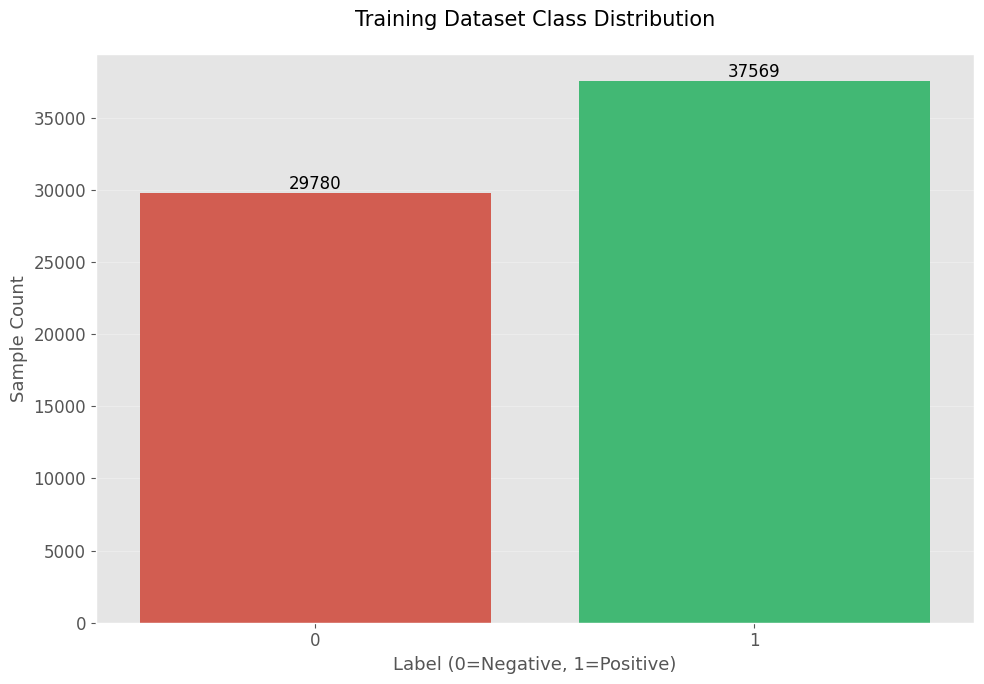


===== Validation Dataset Information =====
Number of samples: 872

Class distribution:
label
0    428
1    444
Name: count, dtype: int64
Class distribution ratio: label
0    0.490826
1    0.509174
Name: count, dtype: float64


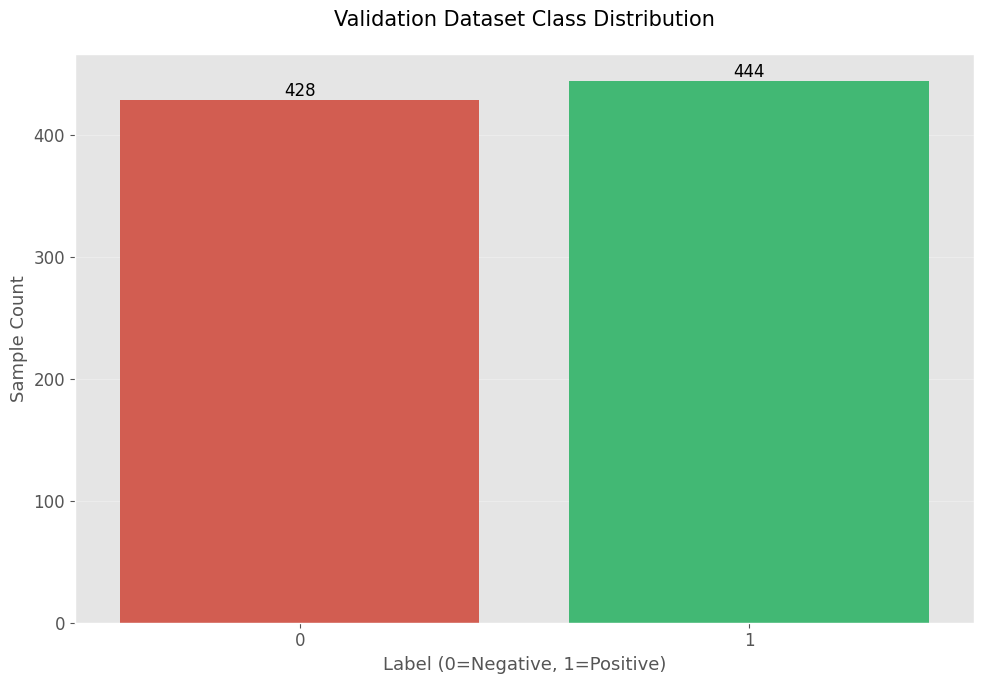


===== Training Dataset Text Length Analysis =====

Text character length statistics:
count    67349.00000
mean        53.50559
std         43.40738
min          2.00000
25%         21.00000
50%         39.00000
75%         74.00000
max        268.00000
Name: text_length, dtype: float64

Word count statistics:
count    67349.000000
mean         9.409553
std          8.073806
min          1.000000
25%          3.000000
50%          7.000000
75%         13.000000
max         52.000000
Name: word_count, dtype: float64

Average word length statistics:
count    67349.000000
mean         5.241508
std          1.789899
min          1.000000
25%          4.111111
50%          4.807692
75%          5.833333
max         24.000000
Name: avg_word_length, dtype: float64


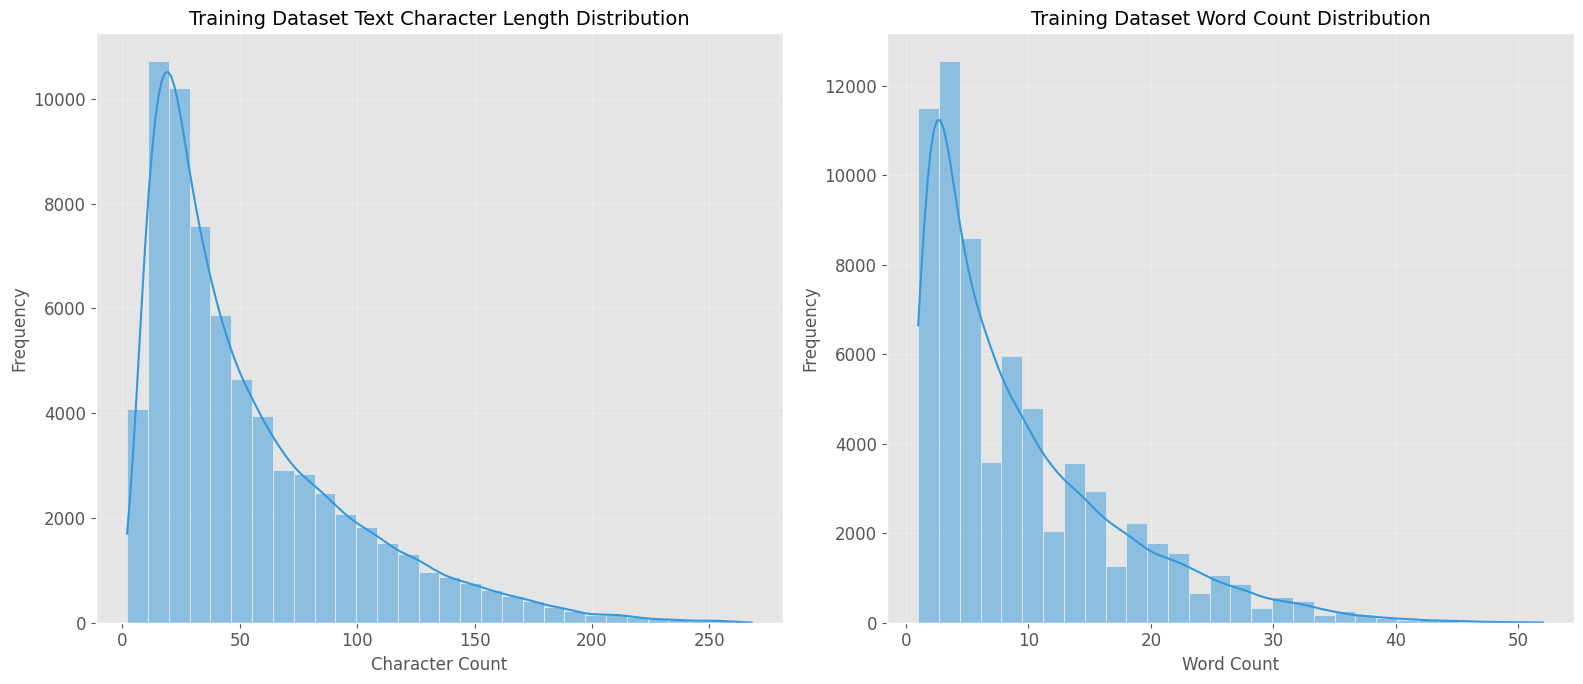

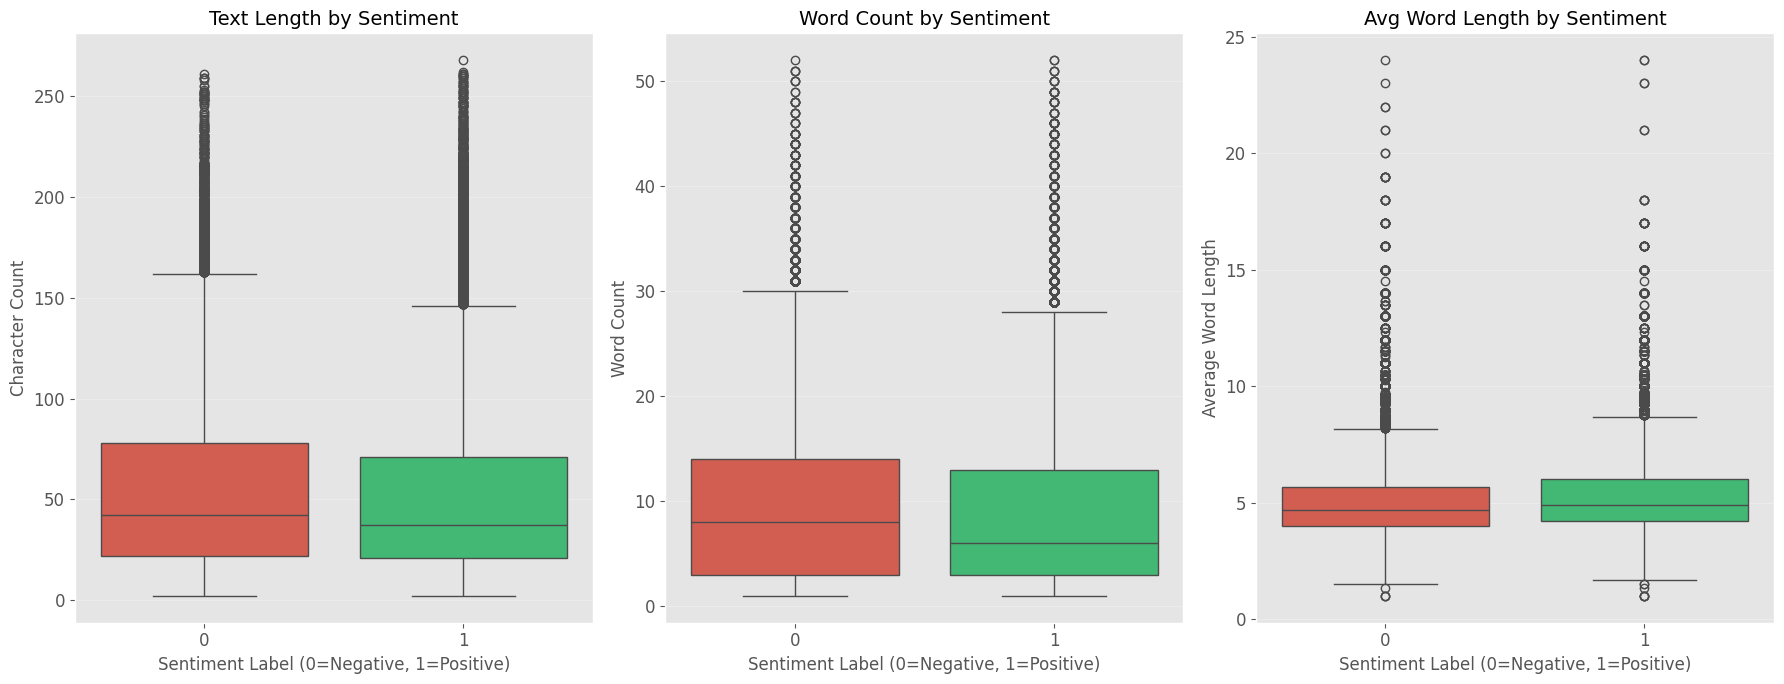


===== Training Dataset Text Complexity Analysis =====

Text complexity statistics:
Average word length statistics:
count    67349.000000
mean         5.241508
std          1.789899
min          1.000000
25%          4.111111
50%          4.807692
75%          5.833333
max         24.000000
Name: avg_word_length, dtype: float64

Punctuation rate statistics:
count    67349.000000
mean         0.020330
std          0.028459
min          0.000000
25%          0.000000
50%          0.010870
75%          0.032258
max          0.500000
Name: punctuation_rate, dtype: float64

Capital letter rate statistics:
count    67349.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: capital_rate, dtype: float64


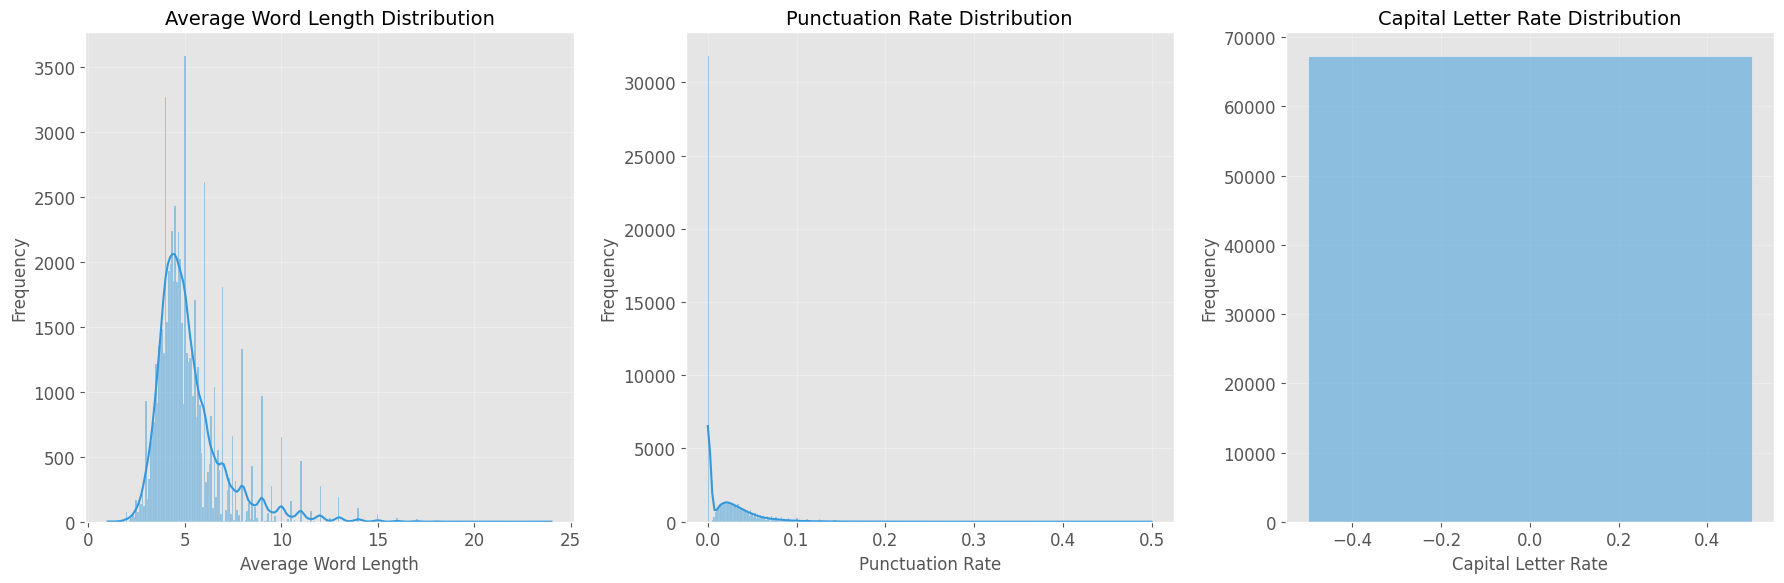

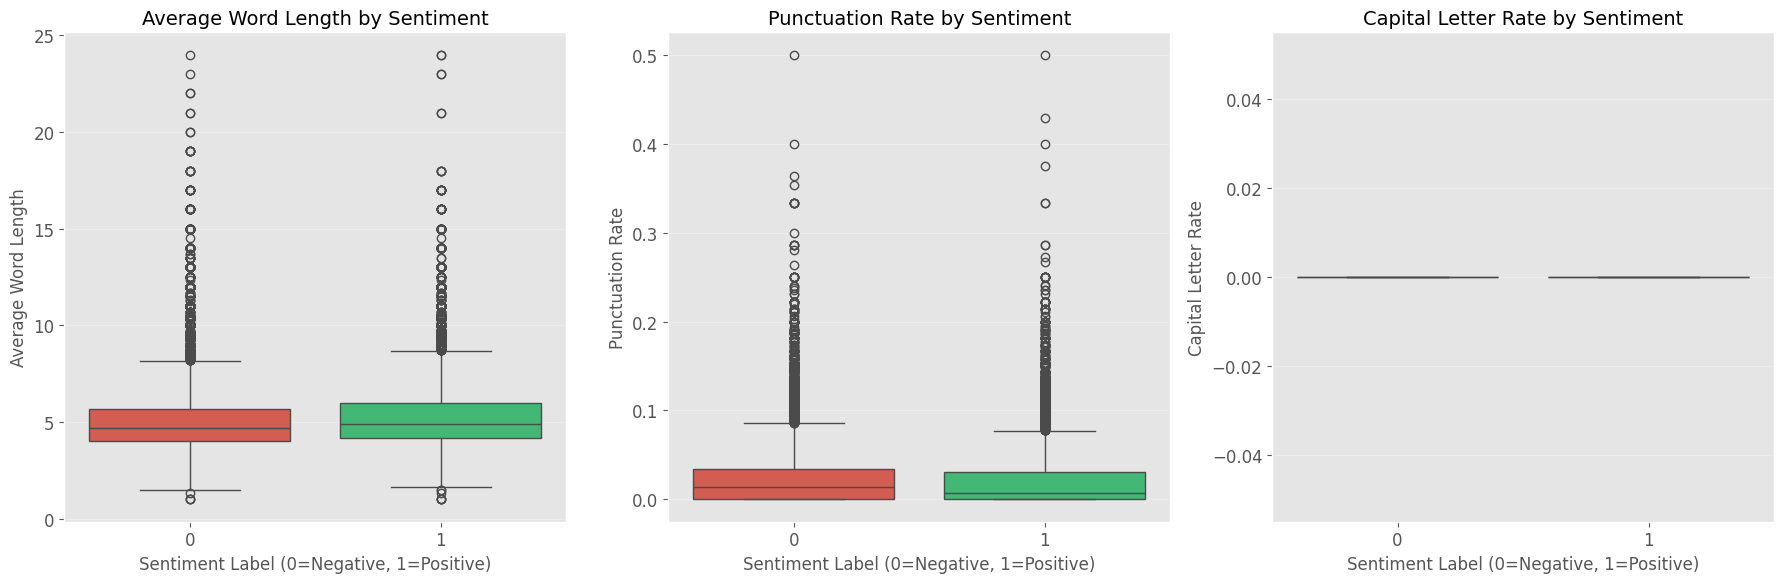


===== Training Dataset Quality Analysis =====
Number of duplicate sentences: 371 (0.55%)
Extremely short sentences (<=3 words): 18542 (27.53%)
Extremely long sentences (>=30 words): 2009 (2.98%)
Sentences with leading spaces: 0 (0.00%)
Sentences with trailing spaces: 67349 (100.00%)
Sentences with special characters: 3118 (4.63%)

Sentiment label distribution:
label
1    0.557826
0    0.442174
Name: proportion, dtype: float64

Sample duplicate sentences:
'a beautifully ' appears 2 times
'a welcome relief ' appears 2 times
'humorless ' appears 2 times
'great ' appears 2 times
'festival ' appears 2 times


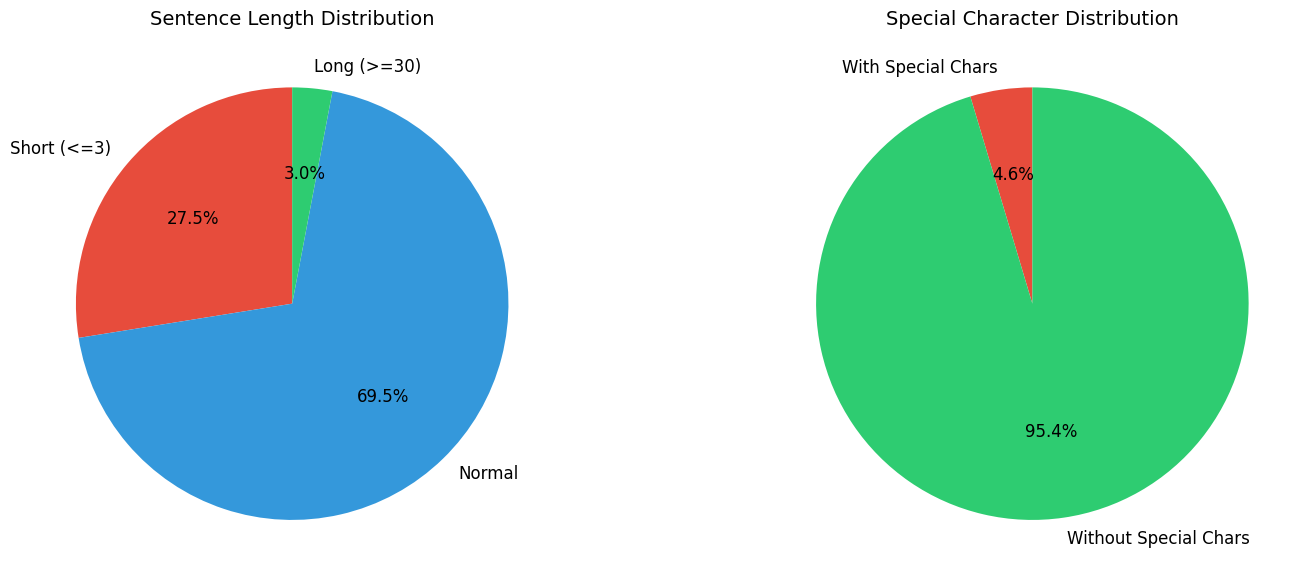


===== Training Dataset Word Frequency Analysis =====


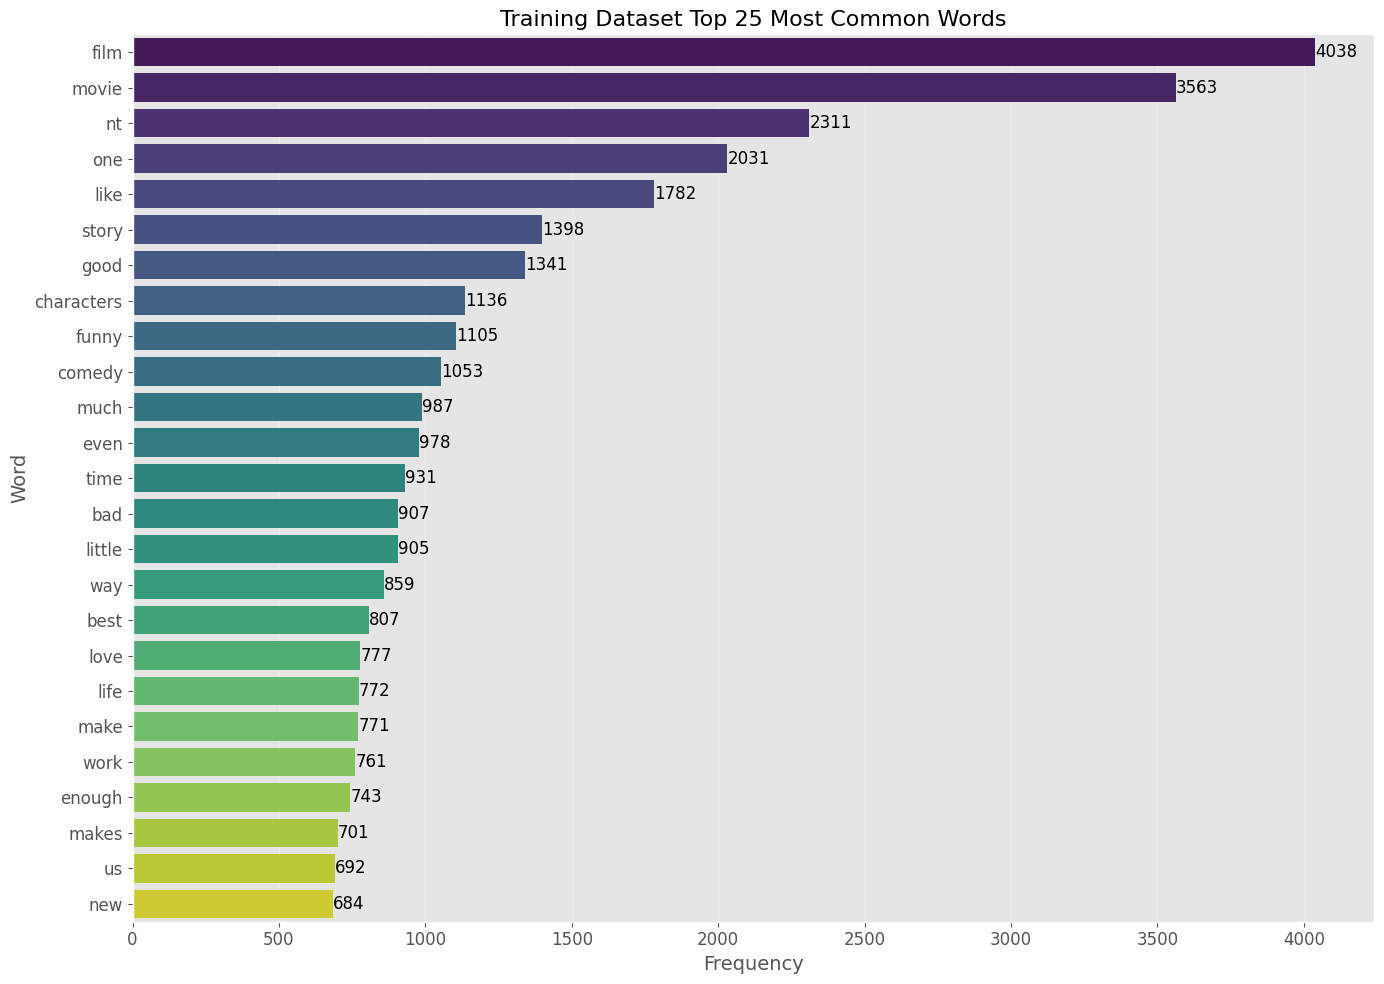

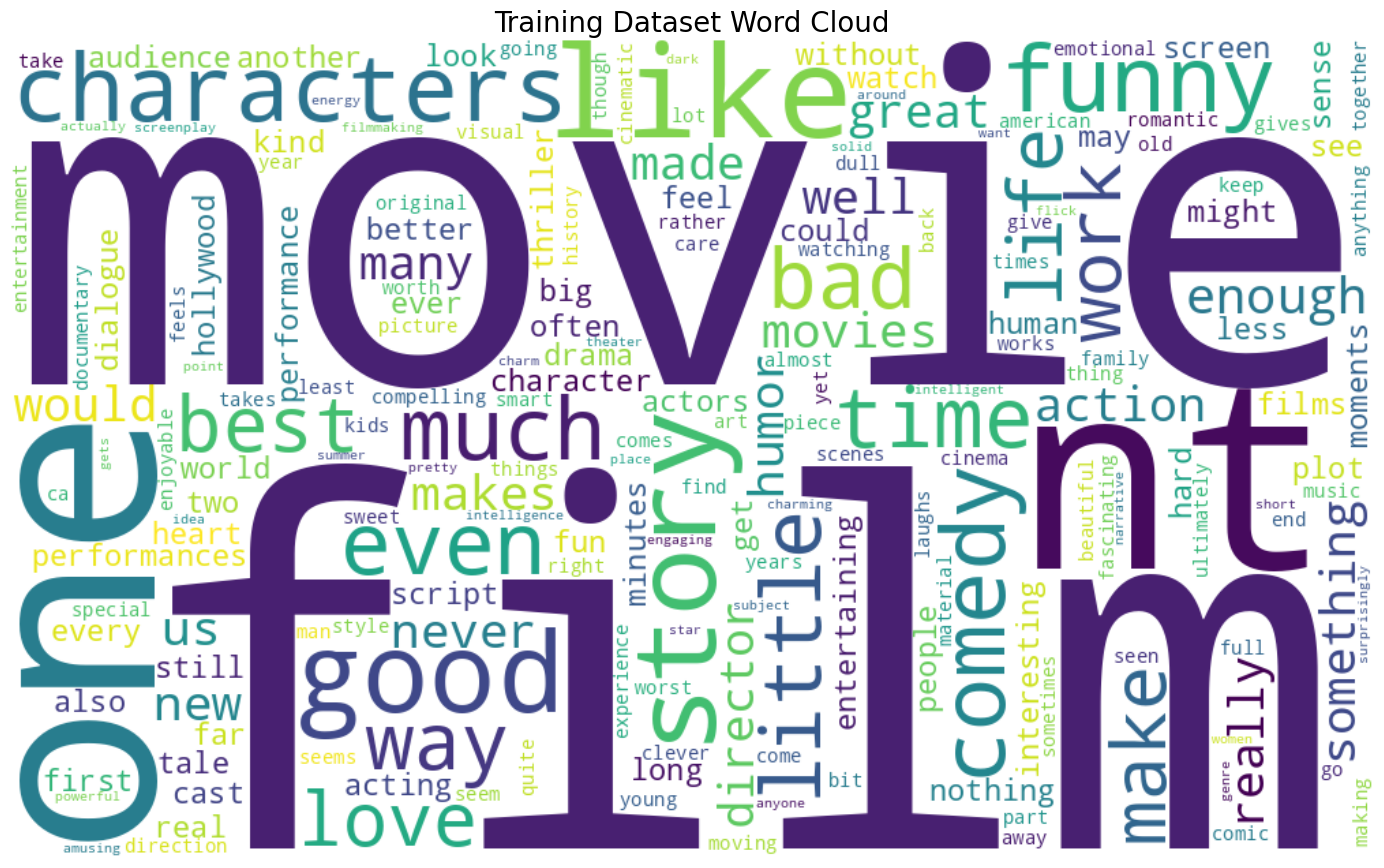

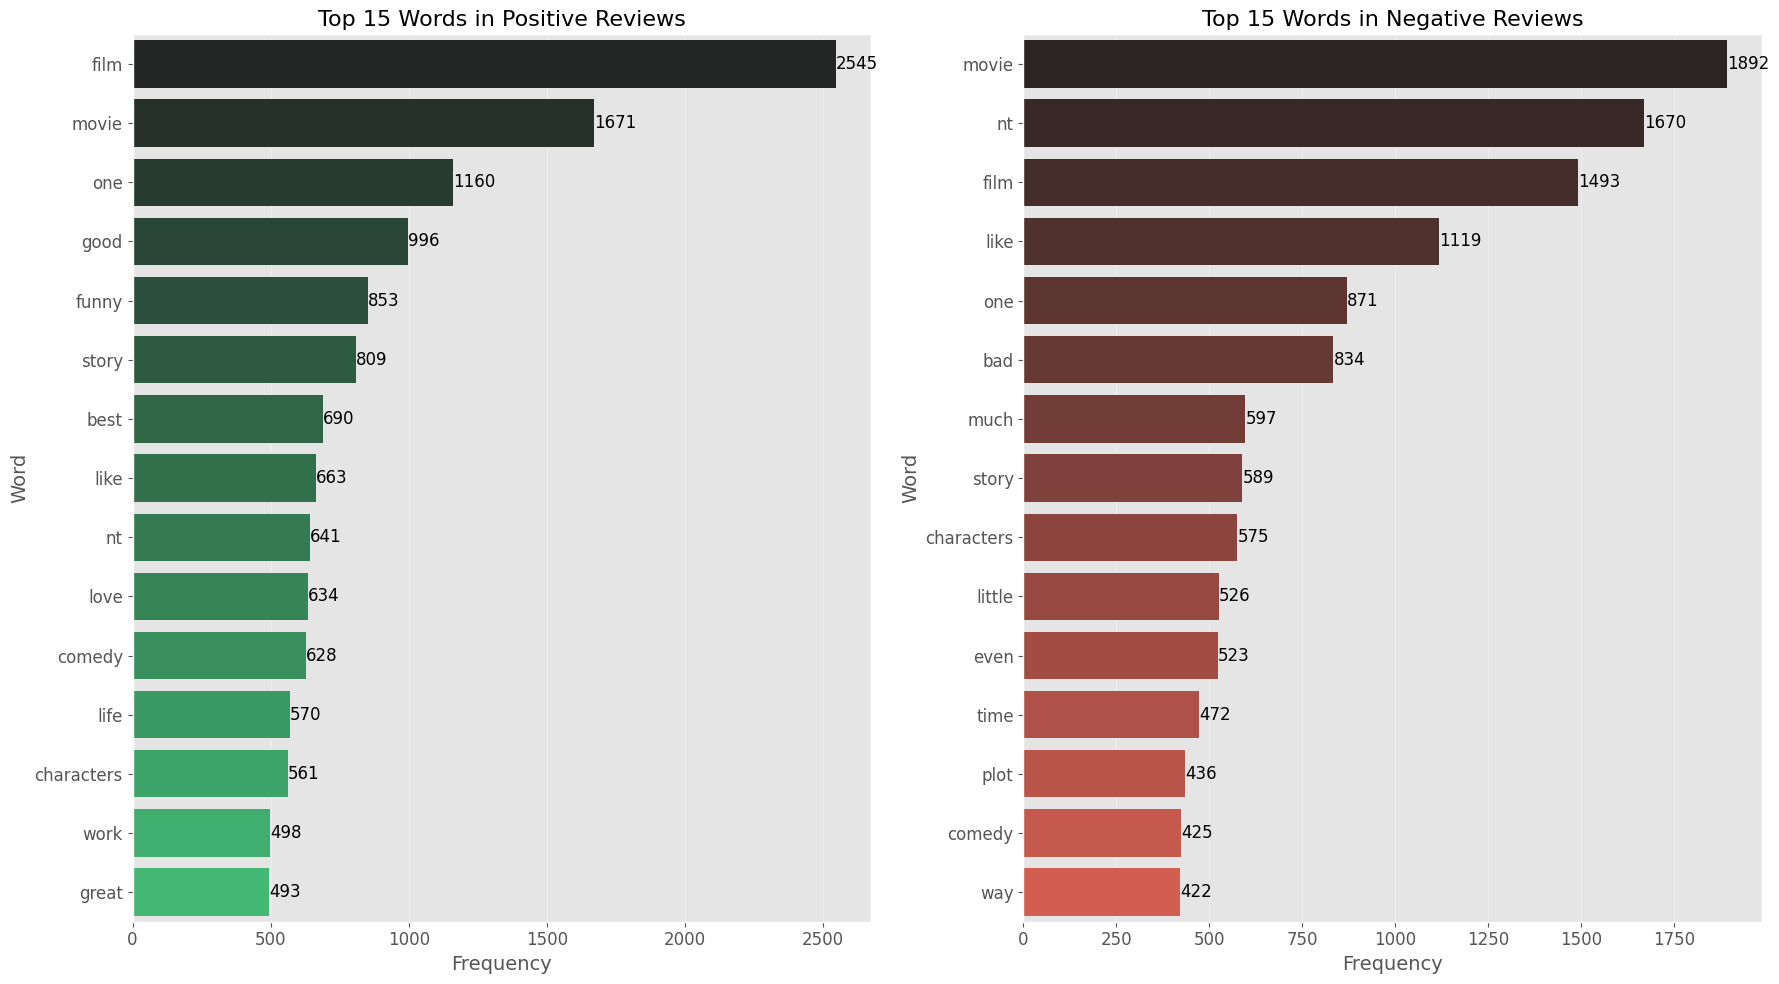

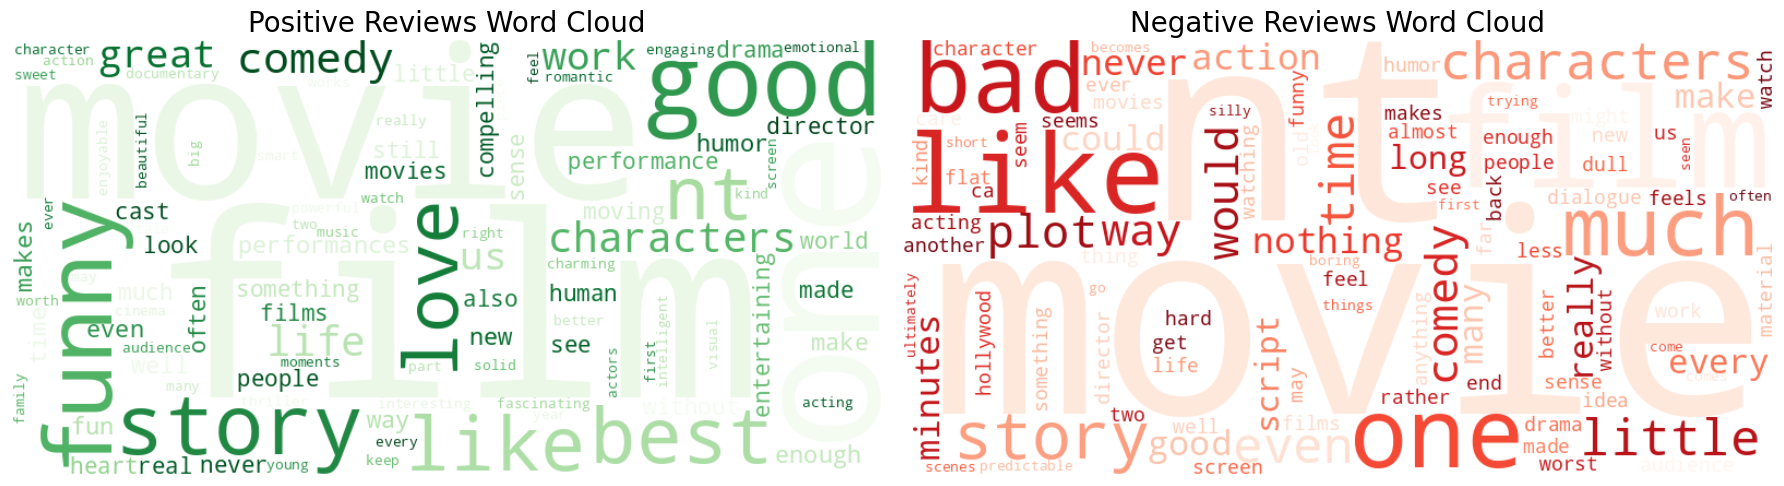


===== Training Dataset 2-gram Analysis =====


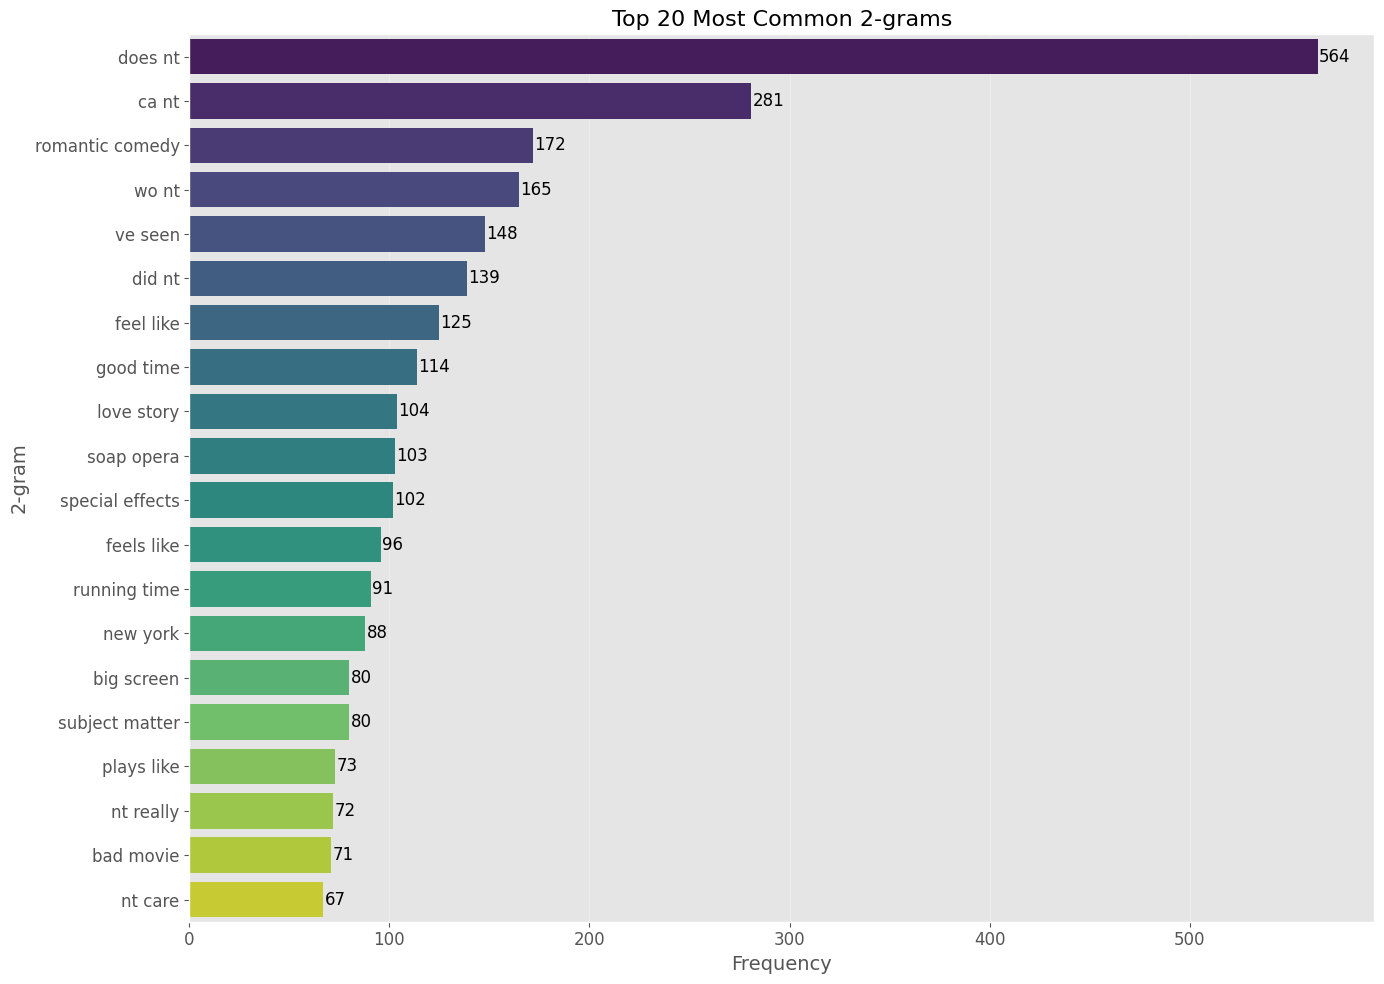

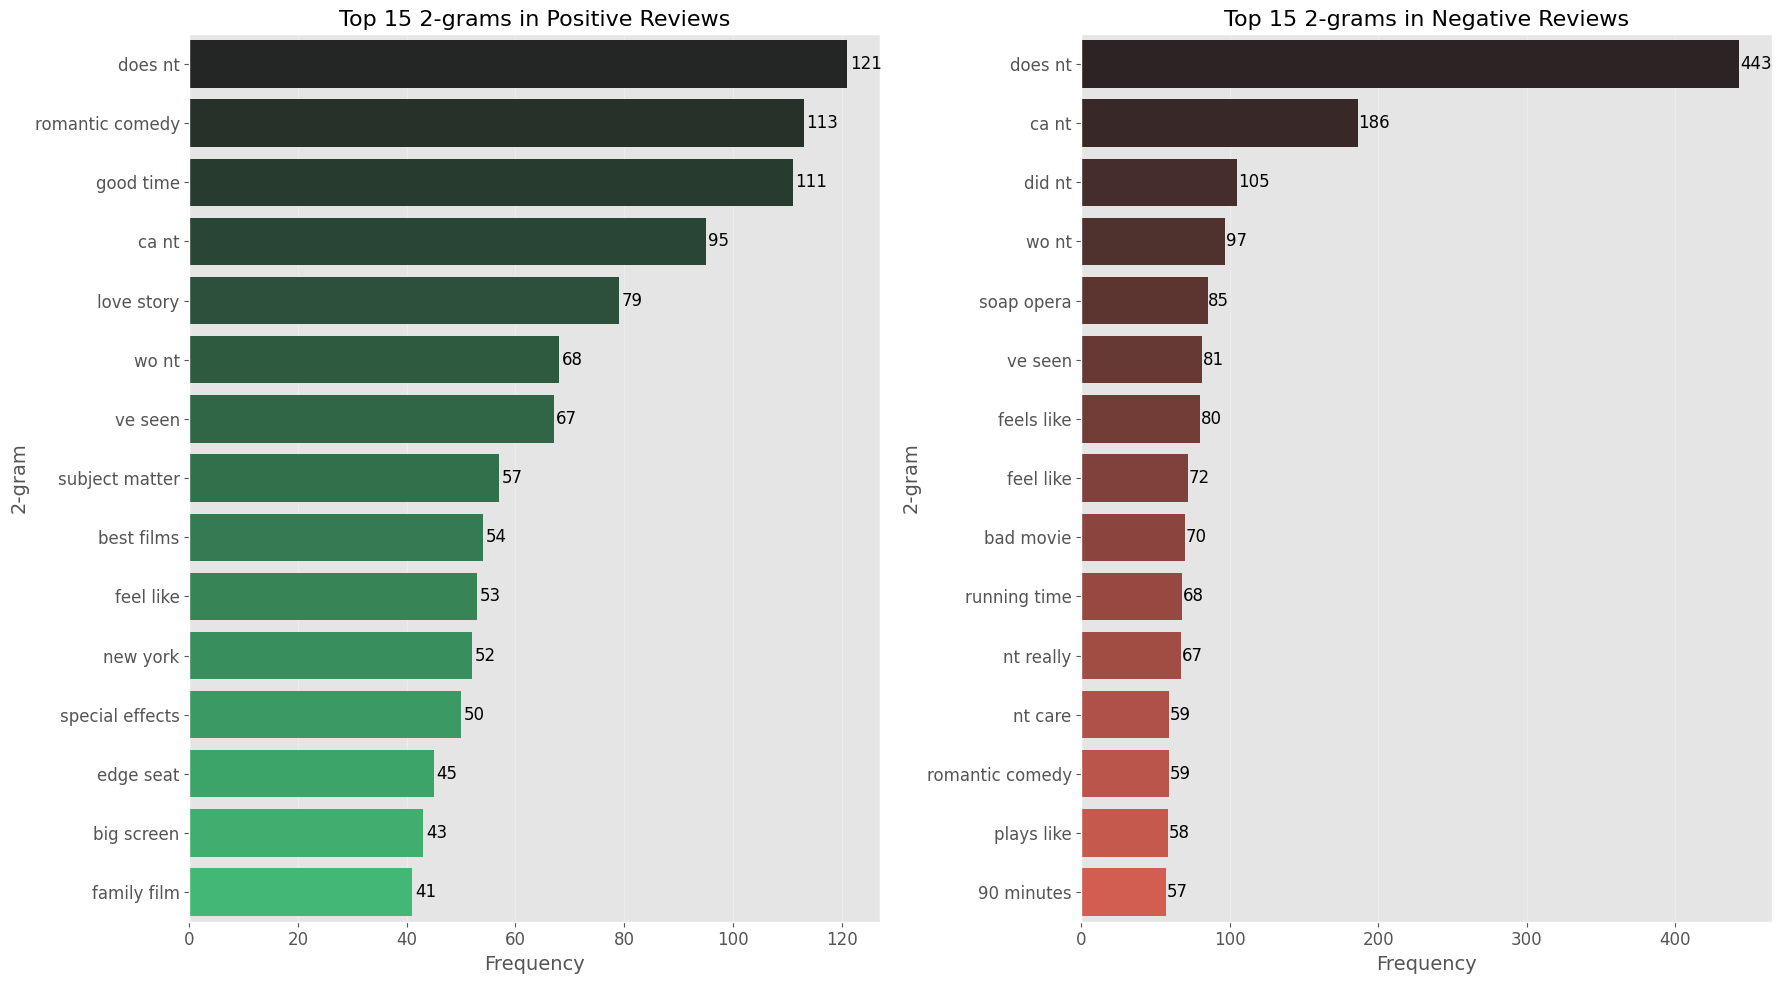


===== Training Dataset 3-gram Analysis =====


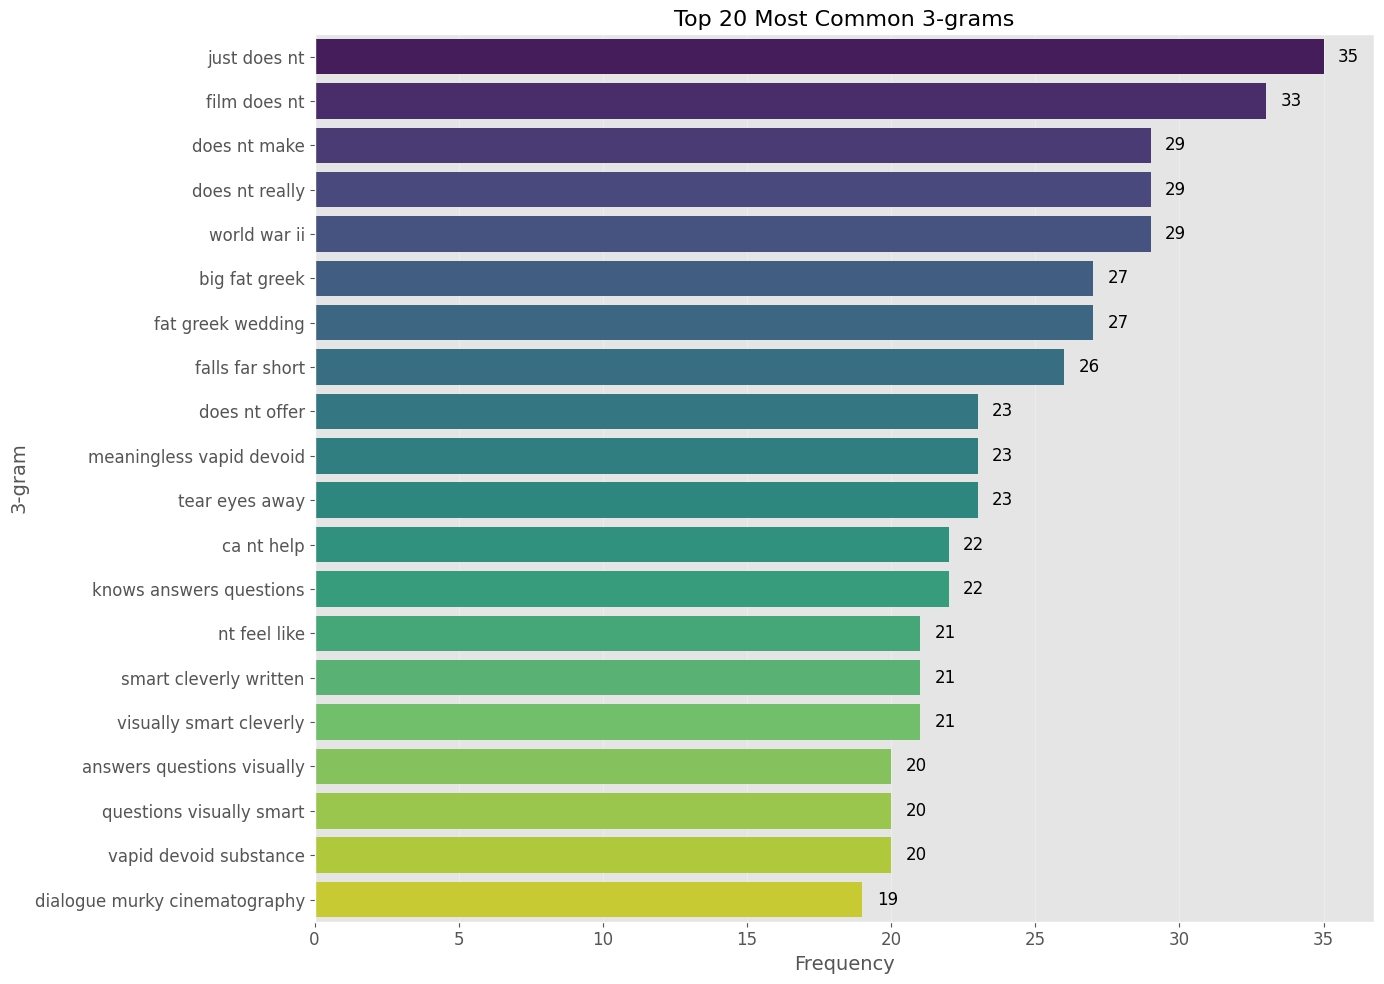

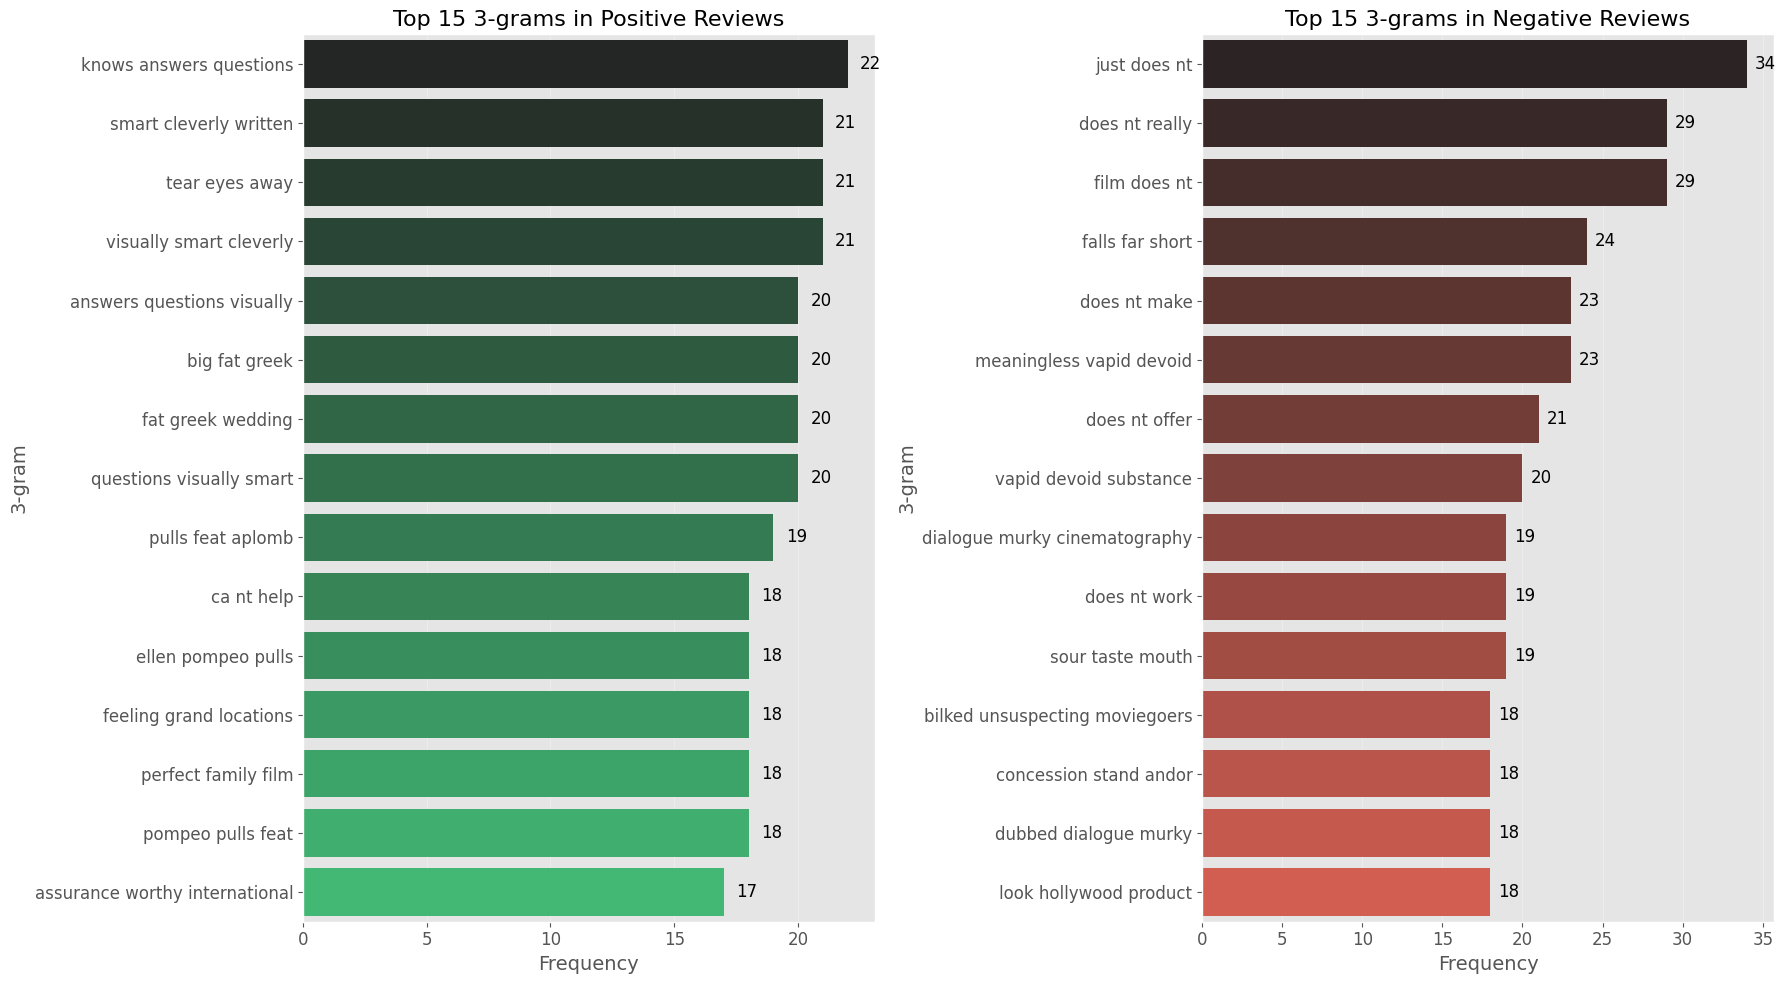


===== Training Dataset Sentiment Intensity Analysis =====

Compound sentiment score statistics:
count    67349.000000
mean         0.115420
std          0.393557
min         -0.975500
25%          0.000000
50%          0.000000
75%          0.440400
max          0.969400
Name: compound_score, dtype: float64


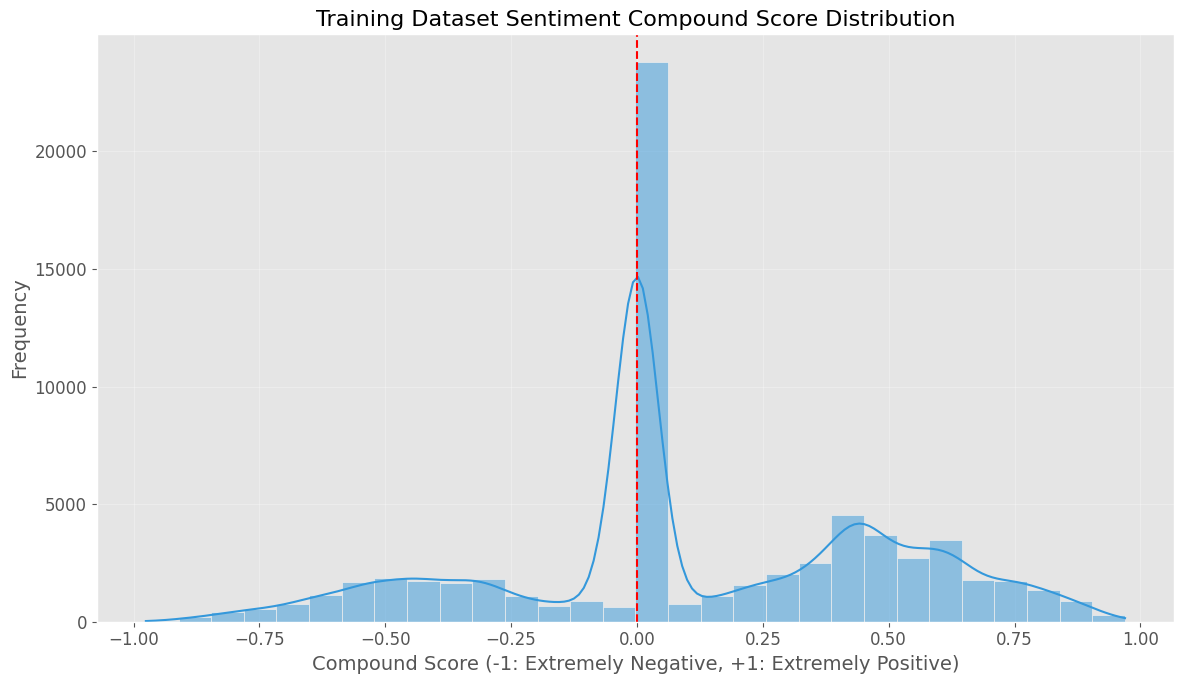


Comparison between dataset labels and VADER sentiment predictions:
              precision    recall  f1-score   support

           0       0.81      0.41      0.54     29780
           1       0.66      0.92      0.77     37569

    accuracy                           0.70     67349
   macro avg       0.74      0.67      0.66     67349
weighted avg       0.73      0.70      0.67     67349



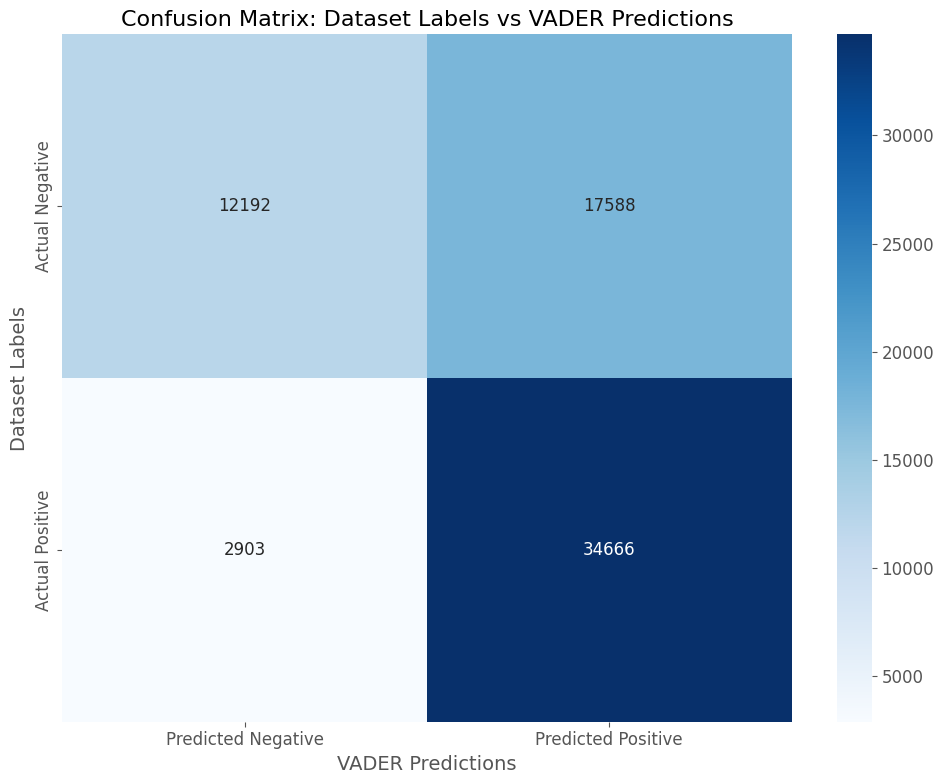

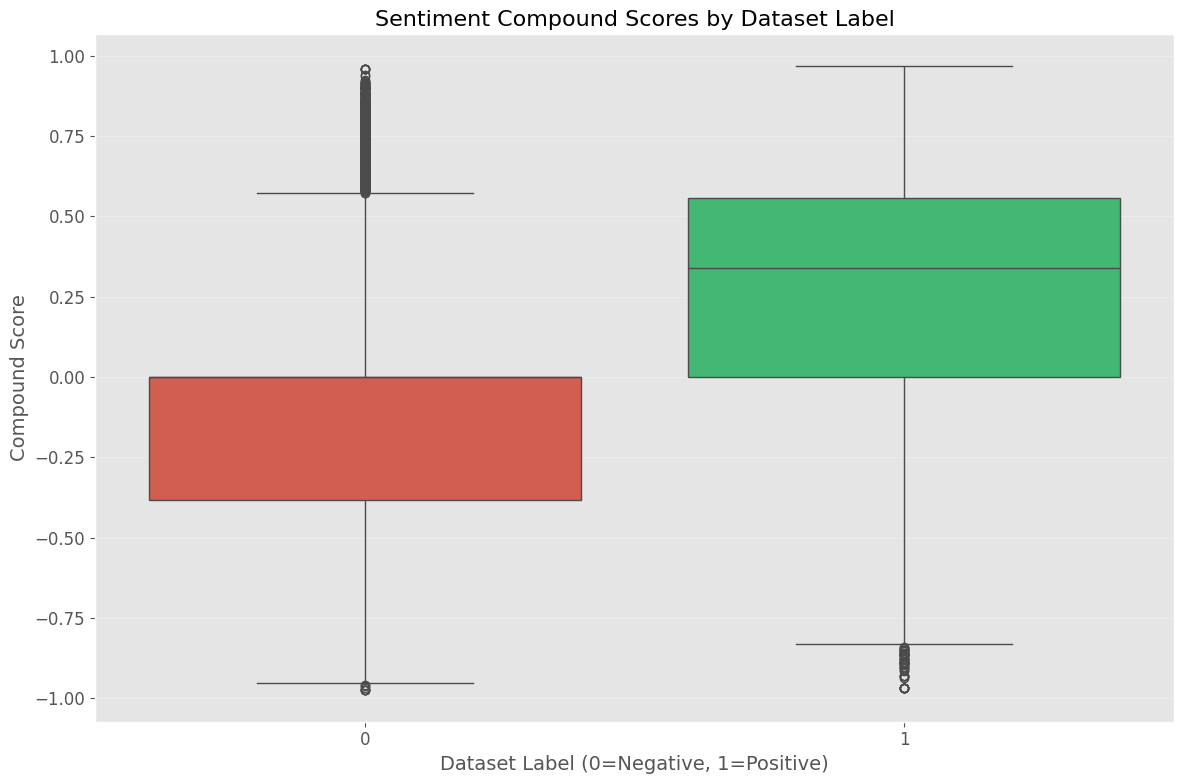


Loading BERT tokenizer...
Processing tokenized data...
Error in tokenizer analysis: name 'process_sst2_data' is not defined
Skipping tokenizer-related analysis

SST-2 Dataset EDA Analysis Complete!
All results saved to: sst2_eda_results


In [12]:
# 10. 主函数，运行所有分析
def main():
    print("Starting SST-2 Dataset EDA Analysis")
    print("===================================")
    
    # 创建输出目录
    os.makedirs(output_dir, exist_ok=True)
    print(f"Results will be saved to: {output_dir}")
    
    # 加载数据集
    datasets, train_data, valid_data = load_sst2_data()
    
    # 1. 基本数据集信息
    train_df = dataset_info(train_data, "Training")
    valid_df = dataset_info(valid_data, "Validation")
    
    # 2. 文本长度分析
    train_df = text_length_analysis(train_data, "Training")
    
    # 3. 文本复杂度分析
    train_df = text_complexity_analysis(train_data, "Training")
    
    # 4. 数据质量分析
    train_df = data_quality_analysis(train_data, "Training")
    
    # 5. 词频分析
    word_frequency_analysis(train_data, "Training")
    
    # 6. N-gram分析
    ngram_analysis(train_data, "Training", n=2)  # 二元语法
    ngram_analysis(train_data, "Training", n=3)  # 三元语法
    
    # 7. 情感强度分析
    sentiment_intensity_analysis(train_data, "Training")
    
    # 加载tokenizer和处理分词数据
    try:
        from transformers import AutoTokenizer
        
        # 使用预训练的BERT tokenizer
        print("\nLoading BERT tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        
        # 处理数据集
        print("Processing tokenized data...")
        tokenized_data = process_sst2_data(tokenizer)
        
        # 8. 分析分词数据
        analyze_tokenized_data(tokenized_data, tokenizer, "SST-2")
        
        # 9. 词-标签相关性分析
        token_label_correlation(tokenized_data, tokenizer, "SST-2")
    except Exception as e:
        print(f"Error in tokenizer analysis: {e}")
        print("Skipping tokenizer-related analysis")
    
    print("\nSST-2 Dataset EDA Analysis Complete!")
    print(f"All results saved to: {output_dir}")

if __name__ == "__main__":
    main()